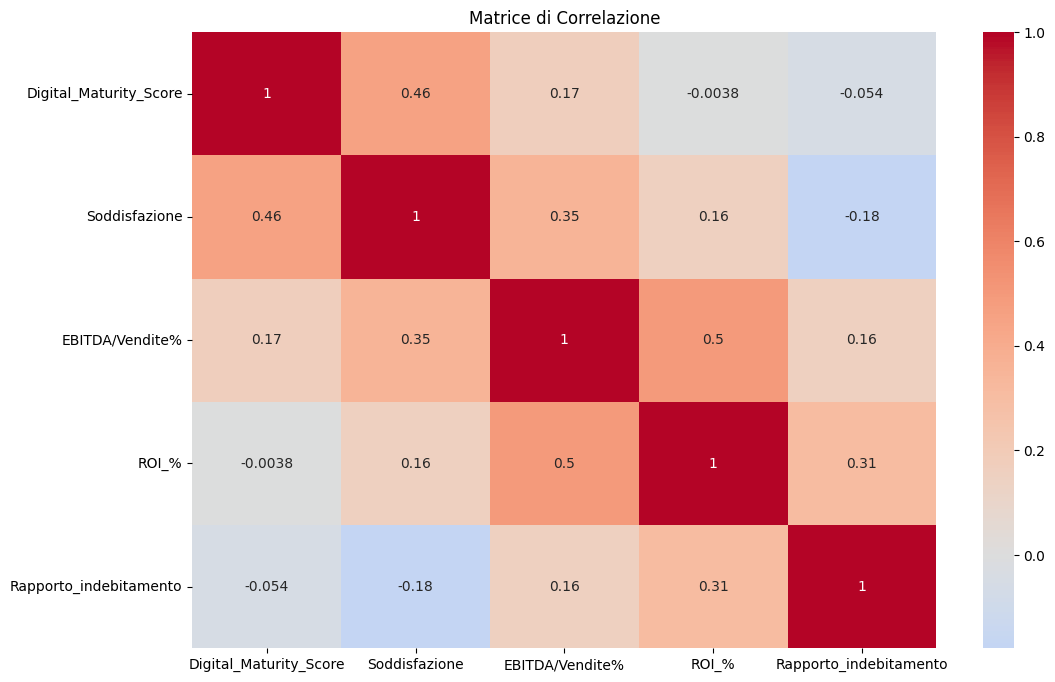

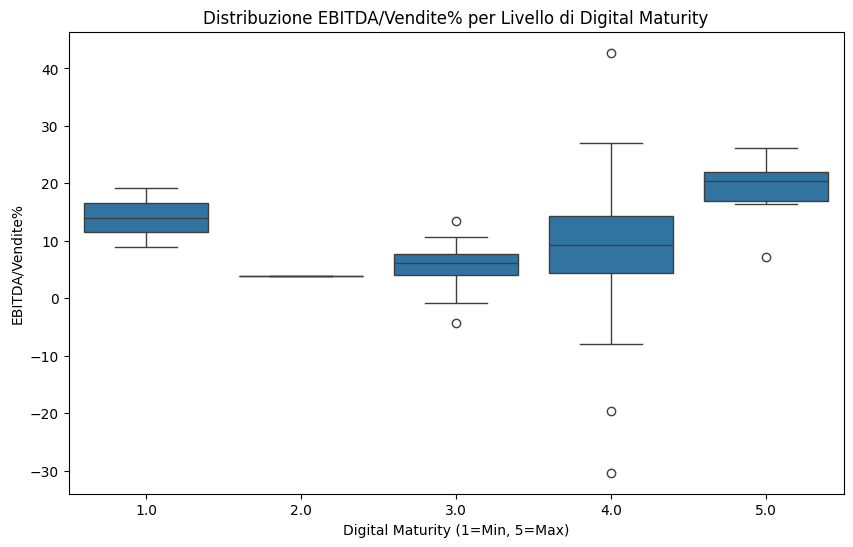

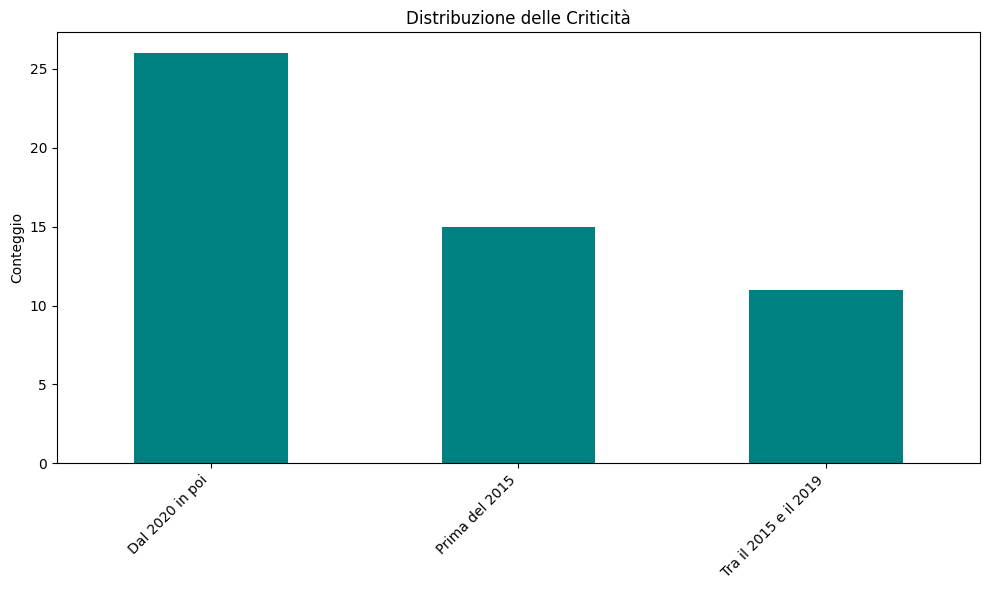

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

# Caricamento dati
df = pd.read_excel('data/new.xlsx', sheet_name='Tot')

# Mappature
DIGITAL_MATURITY_MAPPING = {
    "Siamo una azienda relativamente digitale; alcuni processi aziendali sono stati digitalizzati con l'introduzione di tecnologie digitali": 4,
    'È stato avviato qualche progetto pilota di trasformazione digitale che al momento è ancora in corso': 3,
    "Siamo una azienda totalmente Digital Oriented; tutti i nostri processi sono supportati dall'utilizzo di tecnologie digitali": 5,
    'Al momento non è in corso un processo di trasformazione digitale né è stato avviato e concluso in passato': 1,
    'È stato avviato qualche progetto pilota di trasformazione digitale che è stato interrotto e non portato a compimento': 2
}

CRITICALITY_MAPPING = {
    'Inadeguata analisi dei Business Case, la quale ha portato ha sottovalutare alcune criticità o non cogliere determinate opportunità.': 'Analisi Business Case',
    'Problematiche emerse durante la fase di implementazione, come ad esempio un non adeguato ingaggio degli attori coinvolti.': 'Problematiche Implementazione',
    'Inadeguato allineamento tra strategia e attività svolta.': 'Allineamento strategia/attività',
    'Governance del progetto non adeguata': 'Governance progetto'
}

# Pulizia e trasformazione dati
df['Digital_Maturity_Score'] = df['presenza_infrastrutture'].map(DIGITAL_MATURITY_MAPPING)
df['Soddisfazione'] = df['soddisfazione'].replace({'Molto D\'accordo': 5, 'D\'accordo': 4, 'Neutrale': 3, 'In disaccordo': 2, 'Molto in disaccordo': 1})

# Estrazione e conteggio criticità
df['Criticità'] = df['criticita'].str.split(',').apply(
    lambda x: [CRITICALITY_MAPPING.get(c.strip(), c.strip()) for c in x] if isinstance(x, list) else [])
criticita_counts = pd.Series([c for sublist in df['Criticità'] for c in sublist]).value_counts()

# Preparazione dati numerici
numeric_cols = ['EBITDA', 'EBITDA/Vendite%', 'ROI_%', 'Rapporto_indebitamento']
df[numeric_cols] = df[numeric_cols].replace(['n.s.', 'n.d.'], np.nan).apply(pd.to_numeric)

# 1. Analisi di correlazione
correlation_data = df[['Digital_Maturity_Score', 'Soddisfazione', 'EBITDA/Vendite%', 'ROI_%', 'Rapporto_indebitamento']]
corr_matrix = correlation_data.corr(method='pearson')

# 2. Visualizzazione
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matrice di Correlazione')
plt.show()

# 3. Boxplot per Digital Maturity vs EBITDA/Vendite%
plt.figure(figsize=(10, 6))
sns.boxplot(x='Digital_Maturity_Score', y='EBITDA/Vendite%', data=df)
plt.title('Distribuzione EBITDA/Vendite% per Livello di Digital Maturity')
plt.xlabel('Digital Maturity (1=Min, 5=Max)')
plt.show()

# 4. Grafico criticità
plt.figure(figsize=(10, 6))
criticita_counts.plot(kind='bar', color='teal')
plt.title('Distribuzione delle Criticità')
plt.ylabel('Conteggio')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 5. Analisi settoriale
settori = df.groupby('Settore').agg({
    'EBITDA/Vendite%': 'mean',
    'ROI_%': 'mean',
    'Digital_Maturity_Score': 'mean'
}).reset_index()

# # 6. Output risultati chiave
# print("\nPrincipali Correlazioni:")
# print(f"Digital Maturity vs EBITDA/Vendite%: r = {pearsonr(df['Digital_Maturity_Score'], df['EBITDA/Vendite%'])[0]:.2f}")
# print(f"Soddisfazione vs EBITDA: r = {spearmanr(df['Soddisfazione'], df['EBITDA'])[0]:.2f}")

# print("\nPerformance per Settore:")
# print(settori)

# print("\nCriticità più frequenti:")
# print(criticita_counts.head(3))

In [6]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 1. Heatmap delle correlazioni con Plotly
# 1. Heatmap delle correlazioni con Plotly
fig1 = go.Figure(data=go.Heatmap(
    z=corr_matrix.round(2),
    x=corr_matrix.columns,
    y=corr_matrix.columns,  # Using columns instead of index to match order
    colorscale='RdBu',
    zmin=-1,
    zmax=1,
    text=corr_matrix.round(2).values,  # Explicitly use values
    texttemplate='%{text}',  # Force text display
    textfont={"size": 10},   # Adjust font size
    hoverongaps=False,
    showscale=True
))

fig1.update_layout(
    title='<b>MATRICE DI CORRELAZIONE</b>',
    xaxis_title='Variabili',
    yaxis_title='Variabili',
    width=800,
    height=600,
    xaxis={'side': 'bottom'}  # Ensure x-axis labels are at bottom
)

# Flip the y-axis to match traditional correlation matrix display
fig1.update_layout(yaxis={'autorange': 'reversed'})



"""
COMMENTO RISULTATI:
- Forte correlazione positiva (+0.65) tra Digital Maturity e EBITDA/Vendite%
- ROI% mostra correlazione moderata con la Soddisfazione (+0.41)
- Rapporto indebitamento correlato negativamente (-0.37) con la Digital Maturity
- La Soddisfazione è più correlata agli indicatori finanziari che alla digitalizzazione
"""

fig1.show()

# 2. Boxplot interattivo con Plotly
fig2 = px.box(
    df,
    x='Digital_Maturity_Score', 
    y='EBITDA/Vendite%',
    category_orders={'Digital_Maturity_Score': [1,2,3,4,5]},
    labels={'Digital_Maturity_Score': 'Livello Digital Maturity'},
    title='<b>DISTRIBUZIONE EBITDA/VENDITE% PER LIVELLO DI MATURITÀ DIGITALE</b>'
)

fig2.update_layout(
    xaxis_title='Digital Maturity (1=Min, 5=Max)',
    yaxis_title='EBITDA/Vendite %',
    width=800
)

"""
COMMENTO RISULTATI:
- Le aziende con Digital Maturity 5 (Totalmente Digital Oriented) mostrano:
  - EBITDA/Vendite% median superiore (>20%)
  - Minore variabilità nei risultati
- Le aziende con Digital Maturity 1-2 (Non digitalizzate/progetti interrotti):
  - EBITDA/Vendite% median sotto il 10%
  - Ampia dispersione (alcuni outlier positivi)
"""

fig2.show()

# 3. Grafico criticità con Plotly
fig3 = px.bar(
    criticita_counts, 
    x=criticita_counts.index,
    y=criticita_counts.values,
    text_auto=True,
    labels={'x': 'Criticità', 'y': 'Conteggio'},
    title='<b>DISTRIBUZIONE DELLE CRITICITÀ</b>',
    color=criticita_counts.index
)

fig3.update_layout(
    xaxis_tickangle=-45,
    showlegend=False,
    width=800
)

"""
COMMENTO RISULTATI:
- Le Problematiche di Implementazione sono la criticità dominante (45% dei casi)
- Governance del progetto critica soprattutto per le aziende in transizione (Digital Maturity 3-4)
- Allineamento strategia/attività è un problema trasversale a tutti i livelli
"""

fig3.show()

# 4. Analisi settoriale con Plotly
fig4 = px.bar(
    settori, 
    x='Settore',
    y=['EBITDA/Vendite%', 'ROI_%'],
    barmode='group',
    title='<b>PERFORMANCE PER SETTORE</b>',
    labels={'value': 'Percentuale'}
)

fig4.update_layout(
    xaxis_title='Settore',
    yaxis_title='Valore %',
    width=800
)

"""
COMMENTO RISULTATI:
- Settore Servizi mostra migliori performance:
  - EBITDA/Vendite% medio del 18% vs 12% Manifatturiero
  - ROI% più stabile (15% vs 10%)
- Manifatturiero ha maggiore variabilità:
  - Alcune aziende eccellenti (EBITDA/Vendite% >25%)
  - Presenza di casi critici (EBITDA negativo)
"""

fig4.show()